In [1]:
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pdd_module import *
import pickle

####################################################################
# example beam model raw data


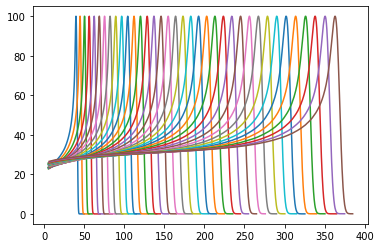

Beam model energies (MeV): 
[70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0, 135.0, 140.0, 145.0, 150.0, 155.0, 160.0, 165.0, 170.0, 175.0, 180.0, 185.0, 190.0, 195.0, 200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0, 245.0]
####################################################################
# example IDD analysis
Metrics generated by PeakProprties class: 
{'NISTRange': 176.3, 'Prox80': 169.1066350148368, 'Prox90': 170.77898398674768, 'Dist90': 175.42377937336815, 'Dist80': 176.30140962288687, 'NISTDiff': 0.0014096228868538674, 'Dist20': 180.425559566787, 'Dist10': 181.56160493827159, 'PTPR': 3.815079334440027, 'FallOff': 4.124149943900136, 'PeakWidth': 7.194774608050068, 'HaloRat': 57.67525440323169}
####################################################################
# example raw data from directory


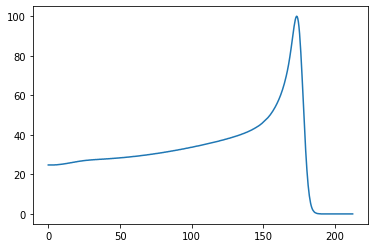

160 MeV IDD data: 
160.0


In [2]:
# examples

#########################################################################
# load IDD raw data
bm_asc = 'TPS_IDD_70-245-MeV_v2.0.asc'
bm_data = DepthDoseFile(bm_asc)

# example beam model raw data
print('####################################################################')
print('# example beam model raw data')
for energy in bm_data.data:
    depth = energy[0]
    dose = energy[1]
    plt.plot(depth, dose)

plt.show()

print("Beam model energies (MeV): ")
print(bm_data.energy)

# example IDD analysis
print('####################################################################')
print('# example IDD analysis')
bm160 = bm_data.data[18]  # select the 160 MeV IDD and analyse its properties
en = bm_data.energy[18]
bm_anal = PeakProperties(data=bm160, energy=en, plateau_depth=25, bortfeld_fit_bool=False)
print('Metrics generated by PeakProprties class: ')
print(bm_anal.__dict__)

# example raw data from directory
print('####################################################################')
print('# example raw data from directory')
mcc_dir = 'O:\protons\Work in Progress\AlexG\pdd-analysis\data\mcc'
data = directory_to_dictionary(mcc_dir)
data_fromdir = data[160.0] # select a 160 MeV IDD from the raw files in the directory
depth = data_fromdir.data[0]
dose = data_fromdir.data[1]
plt.plot(depth, dose)
plt.show()
print('160 MeV IDD data: ')
print(data_fromdir.energy)

# example gamma analysis
test_data = data_fromdir.data
#ref_data = 

#gamma = pdd_gamma(test_data, ref_data, setgamma, crit)

In [3]:
import glob
import pathlib

################ Assess plotting tank set up uncertainty:

### Stingray GA0 vs. GA270 

# load pickle data
pickle_dir = 'C:\\Users\\agrimwoo\\NHS\\(Canc) Radiotherapy - PBT Physics Team - PBT Physics Team\\QAandCommissioning\\Gantry 3\\Commissioning\\IDD\\pickle_jar'

# stingray at GA0
pickle_file = os.path.join(pickle_dir,'20211118_SR_070_240_G0','data_properties.p')
with open(pickle_file, 'rb') as f:
    sr_g0 = pickle.load(f)

# stingray at GA270 for 70 MeV to 160 MeV
pickle_file = os.path.join(pickle_dir,'20211102_SR_070_160_G270','data_properties.p')
with open(pickle_file, 'rb') as f:
    sr_g270_1 = pickle.load(f)

# stingray at GA270 for 165 MeV to 245 MeV
pickle_file = os.path.join(pickle_dir,'20211101_SR_165_245_G270','data_properties.p')
with open(pickle_file, 'rb') as f:
    sr_g270_2 = pickle.load(f)

# concatenate stingray GA270 datasets
sr_g270 = {**sr_g270_1, **sr_g270_2}

D80 Differences between GA 270 & GA0 for stingray at each energy: 


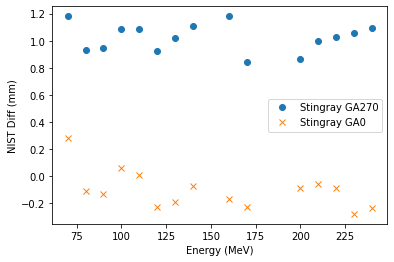

Stingray GA270-GA0 mean (StDev) D80 offset = 1.12 (0.131) mm
Stingray GA0 mean (StDev) NIST Difference = -0.10 (0.137) mm
Stingray GA270 mean (StDev) NIST Difference = 1.02 (0.100) mm


In [4]:
# Quantify GA270 & GA0 offset uncertainty by matching GA0 D80s to G270 D80s, and by assessing NIST depth differences
diff_d80 = []
sr270_nist = []
sr0_nist = []
sr_recorded_energies = []
energies = np.arange(70.0,250.0,5.).tolist()

for en in energies:
    try:
        sr270 = sr_g270[en].Dist80
        sr0 = sr_g0[en].Dist80
    except:
        continue
    
    diff_d80.append(sr270-sr0)
    sr270_nist.append(sr_g270[en].NISTDiff)
    sr0_nist.append(sr_g0[en].NISTDiff)
    sr_recorded_energies.append(en)

sr_avg_offset = np.average(diff_d80)
sr_sd_offset = np.std(diff_d80)
sr_avg_nist270 = np.average(sr270_nist)
sr_avg_nist0 = np.average(sr0_nist)
sr_std_nist270 = np.std(sr270_nist)
sr_std_nist0 = np.std(sr0_nist)

print("D80 Differences between GA 270 & GA0 for stingray at each energy: ")
#print(diff_d80)
plt.plot(sr_recorded_energies,sr270_nist,'o')
plt.plot(sr_recorded_energies,sr0_nist,'x')
plt.xlabel('Energy (MeV)')
plt.ylabel('NIST Diff (mm)')
plt.legend(['Stingray GA270','Stingray GA0'])
plt.show()
print(f'Stingray GA270-GA0 mean (StDev) D80 offset = {sr_avg_offset:.2f} ({sr_sd_offset:.3f}) mm')
print(f'Stingray GA0 mean (StDev) NIST Difference = {sr_avg_nist0:.2f} ({sr_std_nist0:.3f}) mm')
print(f'Stingray GA270 mean (StDev) NIST Difference = {sr_avg_nist270:.2f} ({sr_std_nist270:.3f}) mm')



In [5]:
### Bragg Peak GA0 vs. GA270 
# load pickle data
pickle_dir = 'C:\\Users\\agrimwoo\\NHS\\(Canc) Radiotherapy - PBT Physics Team - PBT Physics Team\\QAandCommissioning\\Gantry 3\\Commissioning\\IDD\\pickle_jar'

# bragg peak at GA0
pickle_file = os.path.join(pickle_dir,'20211125_BP_070_230_G0','data_properties.p')
with open(pickle_file, 'rb') as f:
    bp_g0 = pickle.load(f)

# bragg peak at GA270
pickle_file = os.path.join(pickle_dir,'20211124_BP_070_240_G270','data_properties.p')
with open(pickle_file, 'rb') as f:
    bp_g270 = pickle.load(f)

D80 Differences between GA 270 & GA0 for bragg peak at each energy: 


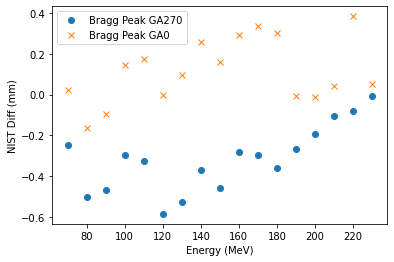

Bragg peak GA270-GA0 mean (StDev) D80 offset = -0.43 (0.188) mm
Bragg peak GA0 mean (StDev) NIST Difference = 0.12 (0.153) mm
Bragg peak GA270 mean (StDev) NIST Difference = -0.31 (0.157) mm


In [6]:
# Correct GA270 offset uncertainty by matching GA0 D80s to G270 D80s
diff_d80 = []
bp270_nist = []
bp0_nist = []
bp_recorded_energies = []
energies = np.arange(70.0,250.0,5.).tolist()

for en in energies:
    try:
        bp270 = bp_g270[en].Dist80
        bp0 = bp_g0[en].Dist80
    except:
        continue
    
    diff_d80.append(bp270-bp0)
    bp270_nist.append(bp_g270[en].NISTDiff)
    bp0_nist.append(bp_g0[en].NISTDiff)
    bp_recorded_energies.append(en)

bp_avg_offset = np.average(diff_d80)
bp_sd_offset = np.std(diff_d80)
bp_avg_nist270 = np.average(bp270_nist)
bp_avg_nist0 = np.average(bp0_nist)
bp_std_nist270 = np.std(bp270_nist)
bp_std_nist0 = np.std(bp0_nist)

print("D80 Differences between GA 270 & GA0 for bragg peak at each energy: ")
#print(diff_d80)
plt.plot(bp_recorded_energies,bp270_nist,'o')
plt.plot(bp_recorded_energies,bp0_nist,'x')
plt.xlabel('Energy (MeV)')
plt.ylabel('NIST Diff (mm)')
plt.legend(['Bragg Peak GA270','Bragg Peak GA0'])
plt.show()
print(f'Bragg peak GA270-GA0 mean (StDev) D80 offset = {bp_avg_offset:.2f} ({bp_sd_offset:.3f}) mm')
print(f'Bragg peak GA0 mean (StDev) NIST Difference = {bp_avg_nist0:.2f} ({bp_std_nist0:.3f}) mm')
print(f'Bragg peak GA270 mean (StDev) NIST Difference = {bp_avg_nist270:.2f} ({bp_std_nist270:.3f}) mm')

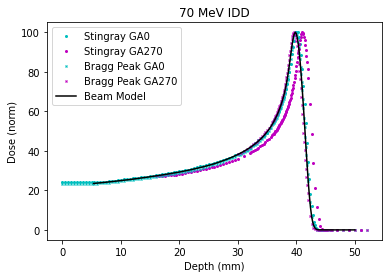

Peak Locations (mm): 
[40.2, 41.0, 39.9, 39.6, 39.8]


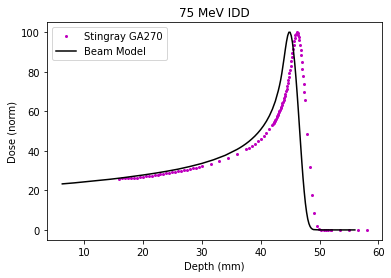

Peak Locations (mm): 
[46.2, 44.8]


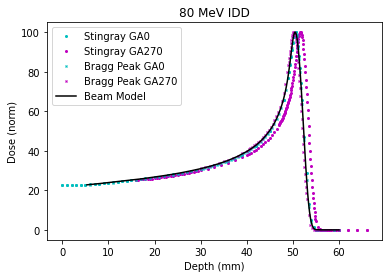

Peak Locations (mm): 
[50.6, 51.6, 50.6, 50.2, 50.4]


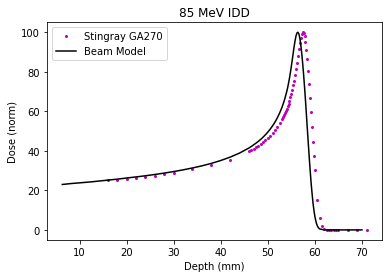

Peak Locations (mm): 
[57.4, 56.4]


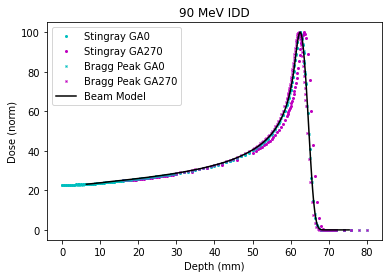

Peak Locations (mm): 
[62.4, 63.6, 62.4, 62.1, 62.6]


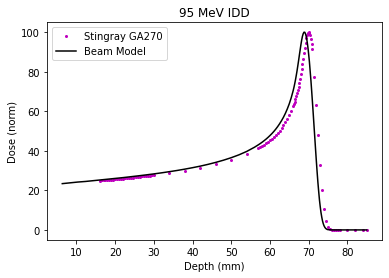

Peak Locations (mm): 
[70.0, 68.8]


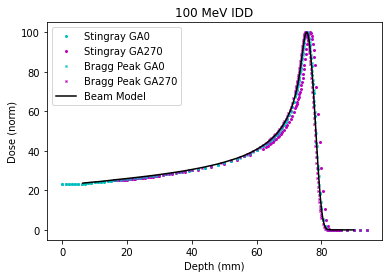

Peak Locations (mm): 
[75.4, 76.6, 75.6, 75.1, 75.4]


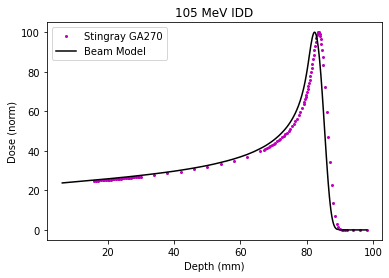

Peak Locations (mm): 
[83.4, 82.4]


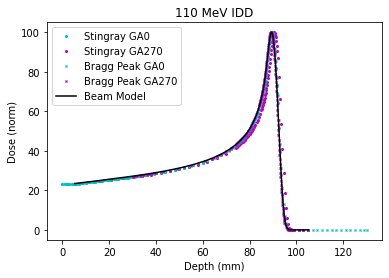

Peak Locations (mm): 
[89.4, 90.6, 89.6, 89.1, 89.4]


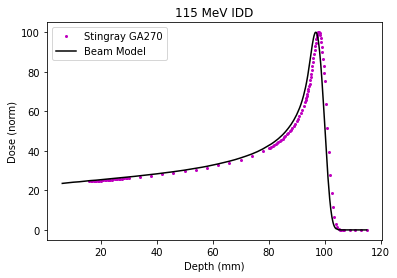

Peak Locations (mm): 
[97.8, 96.8]


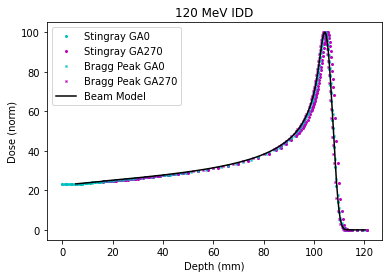

Peak Locations (mm): 
[104.2, 105.4, 104.6, 104.0, 104.4]


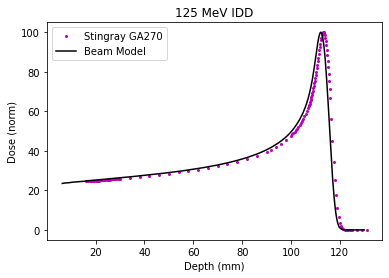

Peak Locations (mm): 
[113.2, 112.2]


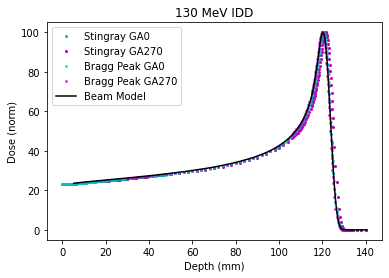

Peak Locations (mm): 
[120.2, 121.4, 120.4, 119.8, 120.2]


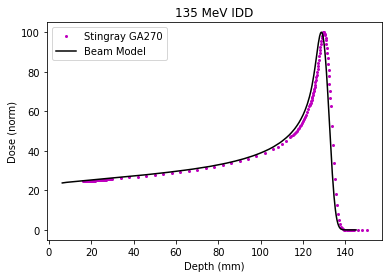

Peak Locations (mm): 
[129.8, 128.6]


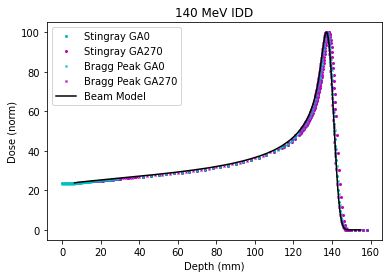

Peak Locations (mm): 
[137.2, 138.4, 137.4, 136.8, 137.2]


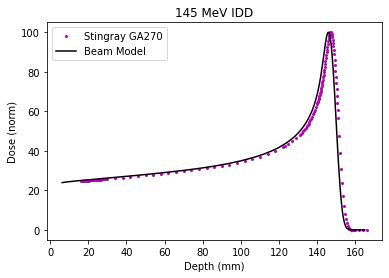

Peak Locations (mm): 
[147.2, 146.0]


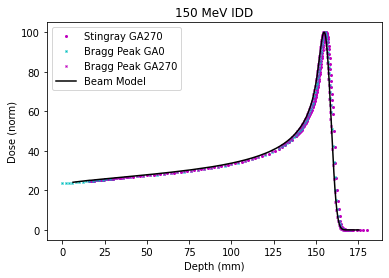

Peak Locations (mm): 
[156.0, 155.2, 154.6, 154.8]


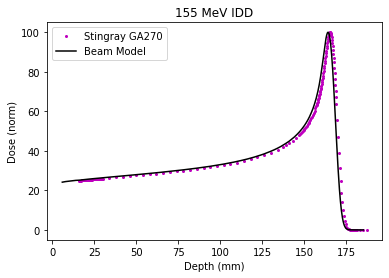

Peak Locations (mm): 
[165.2, 164.0]


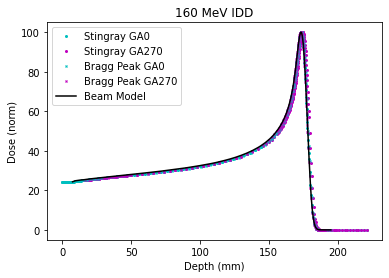

Peak Locations (mm): 
[173.2, 174.6, 173.6, 173.0, 173.4]


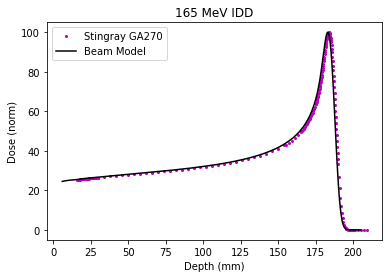

Peak Locations (mm): 
[183.8, 183.0]


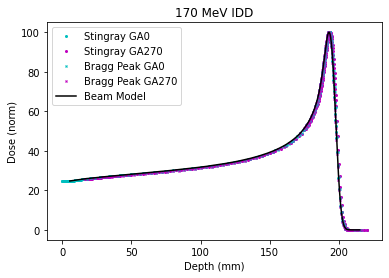

Peak Locations (mm): 
[192.6, 193.6, 193.0, 192.6, 192.8]


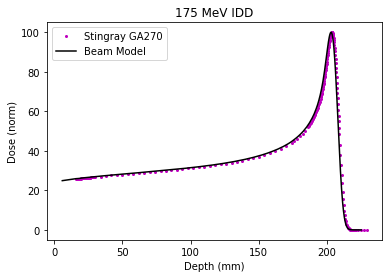

Peak Locations (mm): 
[203.6, 202.8]


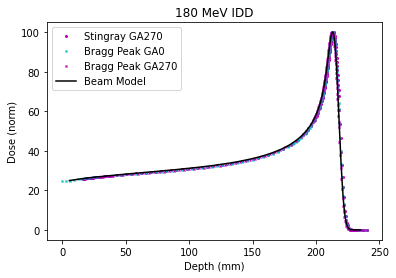

Peak Locations (mm): 
[213.8, 213.4, 212.6, 213.2]


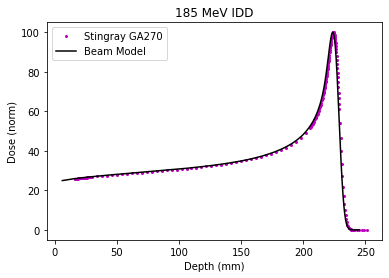

Peak Locations (mm): 
[224.2, 223.6]


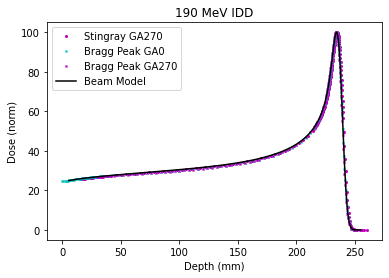

Peak Locations (mm): 
[235.0, 234.0, 233.9, 234.2]


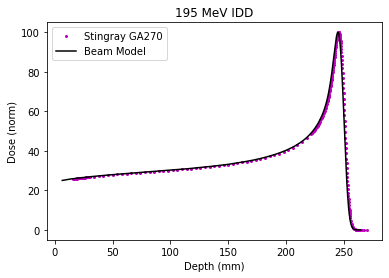

Peak Locations (mm): 
[245.8, 245.2]


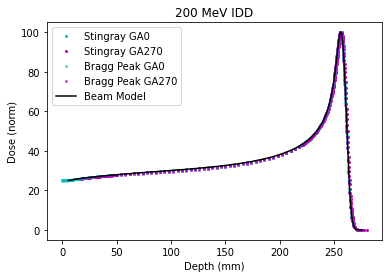

Peak Locations (mm): 
[255.8, 256.8, 256.0, 255.6, 256.2]


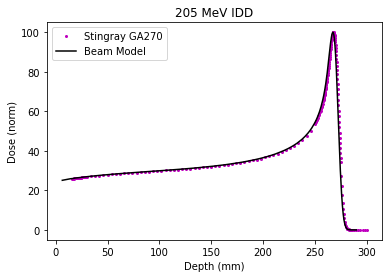

Peak Locations (mm): 
[268.0, 267.4]


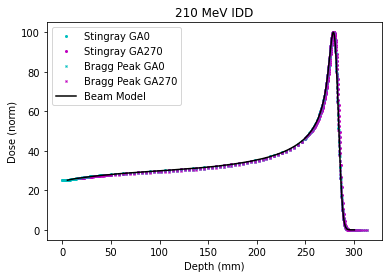

Peak Locations (mm): 
[278.4, 279.4, 278.4, 278.4, 278.6]


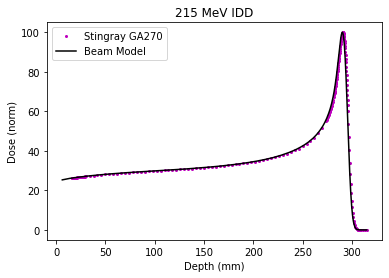

Peak Locations (mm): 
[291.0, 290.2]


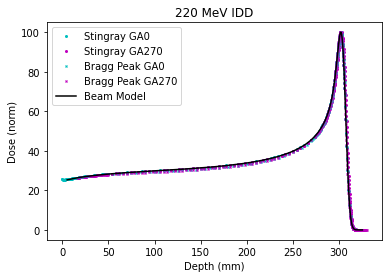

Peak Locations (mm): 
[301.6, 302.6, 302.0, 301.4, 302.0]


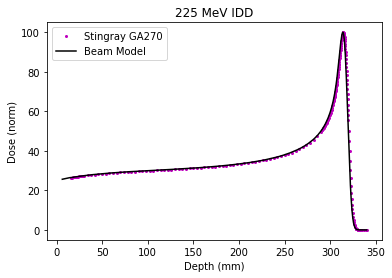

Peak Locations (mm): 
[314.4, 313.8]


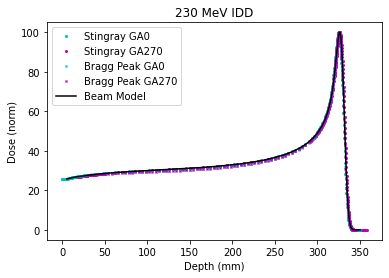

Peak Locations (mm): 
[325.2, 326.6, 325.6, 325.4, 326.2]


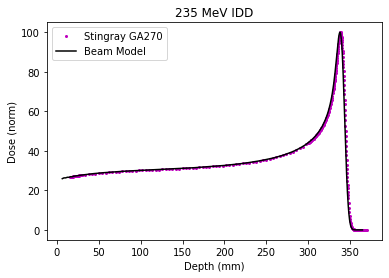

Peak Locations (mm): 
[338.8, 338.0]


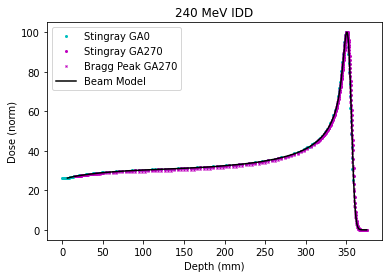

Peak Locations (mm): 
[349.5, 351.2, 349.8, 350.6]


In [22]:
#### Beam model comparison
# load IDD raw data
bm_asc = 'TPS_IDD_70-245-MeV_v2.0.asc'
bm_data = DepthDoseFile(bm_asc)

# load chamber IDD data
# stingray at GA0
pickle_file = os.path.join(pickle_dir,'20211118_SR_070_240_G0','data.p')
with open(pickle_file, 'rb') as f:
    sr_g0 = pickle.load(f)

# stingray at GA270 for 70 MeV to 160 MeV
pickle_file = os.path.join(pickle_dir,'20211102_SR_070_160_G270','data.p')
with open(pickle_file, 'rb') as f:
    sr_g270_1 = pickle.load(f)

# stingray at GA270 for 165 MeV to 245 MeV
pickle_file = os.path.join(pickle_dir,'20211101_SR_165_245_G270','data.p')
with open(pickle_file, 'rb') as f:
    sr_g270_2 = pickle.load(f)

# concatenate stingray GA270 datasets
sr_g270 = {**sr_g270_1, **sr_g270_2}

# bragg peak at GA0
pickle_file = os.path.join(pickle_dir,'20211125_BP_070_230_G0','data.p')
with open(pickle_file, 'rb') as f:
    bp_g0 = pickle.load(f)

# bragg peak at GA270
pickle_file = os.path.join(pickle_dir,'20211124_BP_070_240_G270','data.p')
with open(pickle_file, 'rb') as f:
    bp_g270 = pickle.load(f)

# plot chamber measurements overlaid onto beam model IDDs
energies = np.arange(70.,245.,5.).tolist()
ms=2
for en in energies:
    legend = []
    peak_locs = []
    i=0
    chamber = 'Stingray'
    ga = 0
    try:
        data = sr_g0[en].data
        normalise(data)
        depth = data[0]
        dose = data[1]
        peak_locs.append(depth[np.argmax(dose)])
        legend.append(f'{chamber} GA{ga}')
        plt.plot(depth,dose,'co',ms=ms)
        i += 1
    except:
        pass

    ga = 270
    try:
        data = sr_g270[en].data
        normalise(data)
        depth = data[0]
        dose = data[1]
        peak_locs.append(depth[np.argmax(dose)])
        legend.append(f'{chamber} GA{ga}')
        plt.plot(depth,dose,'mo',ms=ms)
        i += 1
    except:
        pass

    chamber = 'Bragg Peak'
    ga = 0
    try:
        data = bp_g0[en].data
        normalise(data)
        depth = data[0]
        dose = data[1]
        peak_locs.append(depth[np.argmax(dose)])
        legend.append(f'{chamber} GA{ga}')
        plt.plot(depth,dose,'cx',ms=ms)
        i += 1
    except:
        pass

    ga = 270
    try:
        data = bp_g270[en].data
        normalise(data)
        depth = data[0]
        dose = data[1]
        peak_locs.append(depth[np.argmax(dose)])
        legend.append(f'{chamber} GA{ga}')
        plt.plot(depth,dose,'mx',ms=ms)
        i += 1
    except:
        pass

    if i>0:
        idx = bm_data.energy.index(en)
        depth = bm_data.data[idx][0]
        dose = bm_data.data[idx][1]
        peak_locs.append(depth[np.argmax(dose)])
        legend.append('Beam Model')
        plt.plot(depth,dose,'k')
        plt.xlabel('Depth (mm)')
        plt.ylabel('Dose (norm)')
        plt.title(f'{en:.0f} MeV IDD')
        plt.legend(legend)
        plt.show()
        print("Peak Locations (mm): ")
        print(peak_locs)       



In [ ]:
###### IDD Stitching:
# for stingray GA270 add the same 1.2 mm offset to all IDDs
# add Bragg Peak and Stingray IDDs together 
# 

In [43]:
#### Giraffe acceptance comparison

# specify acceptance raw data

# D80 residuals by gantry angle and chamber

In [19]:
#### Gamma analyses by chamber (G3 data)
data = sr_g270[245.].data
normalise(data)
depth = data[0]
dose = data[1]
peak_locs.append(depth[np.argmax(dose)])

In [20]:
peak_locs

[363.6]